In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lifetimes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00


In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

# DATA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [ ]:
df = data.copy()

In [ ]:
df.dropna(axis = 0, subset = ["Description"], inplace = True)

df.dropna(axis = 0, subset = ["Customer ID"], inplace = True)


In [ ]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop(df[df.duplicated()].index, axis=0, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797885 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      797885 non-null  object 
 1   StockCode    797885 non-null  object 
 2   Description  797885 non-null  object 
 3   Quantity     797885 non-null  int64  
 4   InvoiceDate  797885 non-null  object 
 5   Price        797885 non-null  float64
 6   Customer ID  797885 non-null  float64
 7   Country      797885 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 54.8+ MB


# New Feature

In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

Drop row has quantity and price <=0

In [ ]:
df= df[(df['Price'] > 0)]

In [ ]:
df= df[(df['Quantity'] > 0)]

**Drop non-numeric stock**

In [ ]:
# only non-numeric stock
wrong_stock_codes= df[df["StockCode"].astype(str).str.contains(r"^[a-zA-Z''-'\s]{1,40}$")]["StockCode"].unique().tolist()

df[df["StockCode"].isin(wrong_stock_codes)].groupby(["StockCode"]).agg({"StockCode": "count"})

,StockCode
StockCode,
ADJUST,32
BANK CHARGES,31
D,5
DOT,16
M,681
PADS,17
POST,1803


In [ ]:
df= df[~df["StockCode"].isin(wrong_stock_codes)].reset_index(drop=True)

In [ ]:
# other non-numeric stock (number+alphabet)
wrong_stock_codes2= df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
df[df["StockCode"].isin(wrong_stock_codes2)].groupby(["StockCode"]).agg({"StockCode": "count"})

,StockCode
StockCode,
ADJUST2,3
TEST001,9
TEST002,1


In [ ]:
df= df[~df["StockCode"].isin(wrong_stock_codes2)].reset_index(drop=True)

**convert the type of some column**

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Check the minimum and maximum dates
earliest_date = data['InvoiceDate'].min()
latest_date = data['InvoiceDate'].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2009-12-01 07:45:00
Latest Date: 2011-12-09 12:50:00


In [ ]:
df["Customer ID"]= df["Customer ID"].astype('object')

In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
776822,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
776823,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
776824,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
776825,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# RFM Estimation - (Recency, Frequency, Monetary)

RFM là viết tắt của "frequency" (tần suất), "recency" (tính mới), và "monetary" (giá trị tiền tệ), là một kỹ thuật tiếp thị được sử dụng để tìm ra những khách hàng tốt nhất bằng cách phân tích hành vi mua hàng của họ trong quá khứ. Nó bao gồm việc xem xét tần suất mua hàng của họ, tổng số tiền họ đã chi tiêu cho đến nay, thời gian gần đây nhất họ đã mua hàng từ cửa hàng trực tuyến của chúng tôi và những yếu tố tương tự.

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
#calculating the recency, frequency, T, monetary_value
summary = lifetimes.utils.summary_data_from_transaction_data(df, "Customer ID", "InvoiceDate", "TotalPrice")


In [ ]:
summary = summary.reset_index() #resetting the index


In [ ]:
summary.shape


(5853, 5)

A) T - T is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.

B) Recency - Recency is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.

C) Frequency - Frequency is the number of repeat purchases the customer made during the observation period.

D) Monetary - monetary_value is the average monetary amount of each repeat purchase made by a customer.

In [ ]:
summary.head()


,Customer ID,frequency,recency,T,monetary_value
0,12346.0,2.0,322.0,647.0,38662.955000
1,12347.0,7.0,402.0,404.0,615.714286
2,12348.0,4.0,363.0,438.0,359.310000
3,12349.0,2.0,571.0,589.0,1305.085000
4,12350.0,0.0,0.0,310.0,0.000000


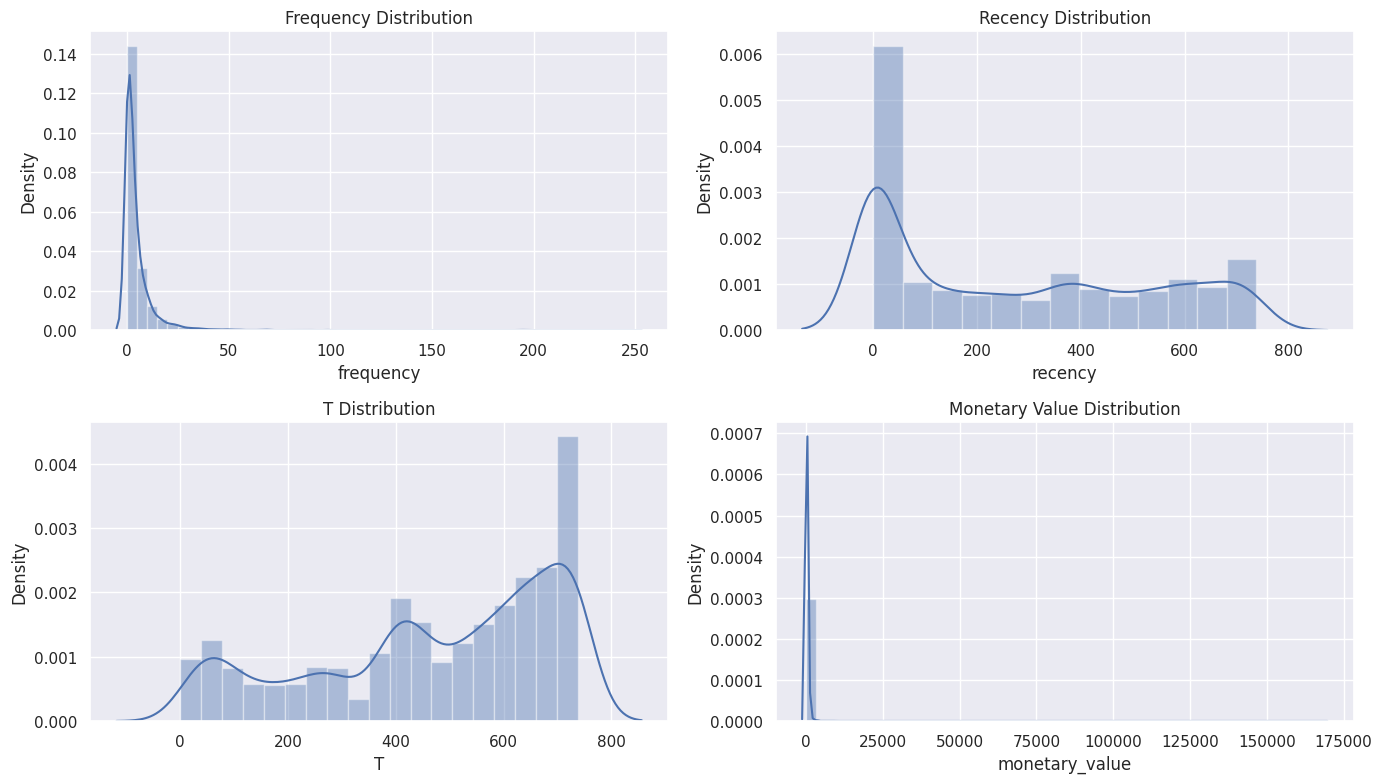

In [ ]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

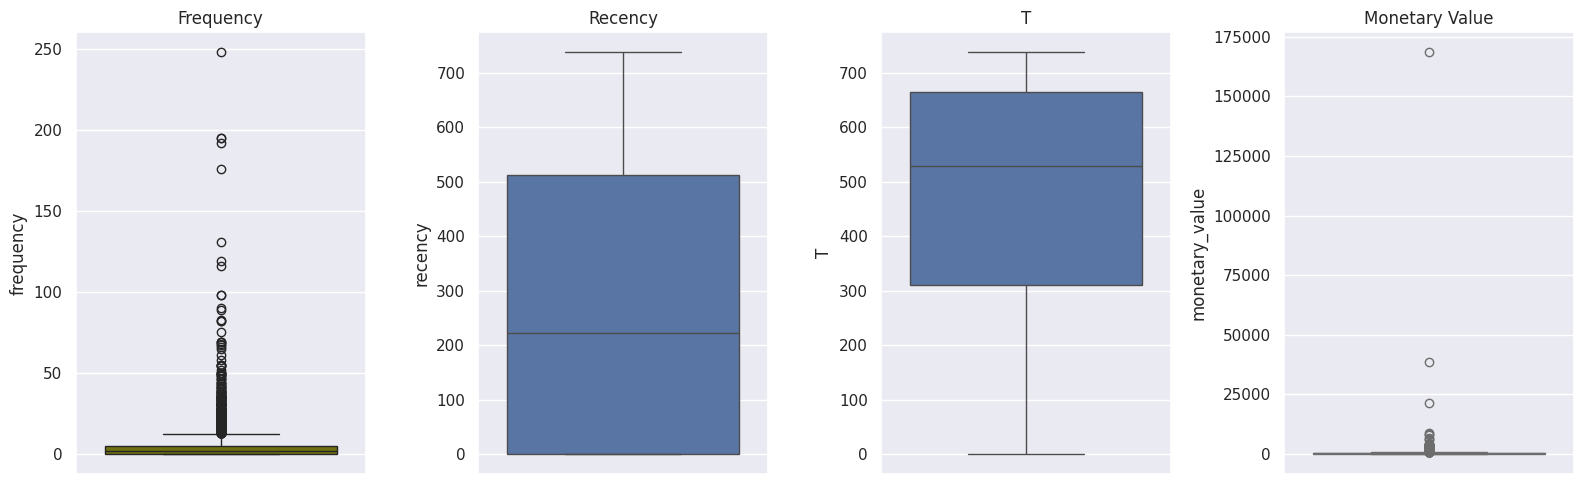

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

In [ ]:
summary.describe()


,Customer ID,frequency,recency,T,monetary_value
count,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000
mean,15319.265847,4.617974,273.761148,473.544507,315.851334
std,1715.115680,9.924267,258.648259,223.176716,2309.171569
min,12346.000000,0.000000,0.000000,0.000000,0.000000
25%,13837.000000,0.000000,0.000000,311.000000,0.000000
50%,15320.000000,2.000000,223.000000,529.000000,206.868000
75%,16802.000000,5.000000,512.000000,666.000000,365.441111
max,18287.000000,248.000000,738.000000,738.000000,168469.600000


In [ ]:
#checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(summary[summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(summary[summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(summary[summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 1674
Total Number of Recency with 0: 1674
Total Number of Monetary Value with 0: 1674


Dữ liệu liên quan đến RFM đã có sẵn, bây giờ chúng ta có thể bắt đầu xem xét mô hình nào có thể xây dựng để dự đoán customer's lifetime value. First we have to figure out either we have to do the prediction based on the customer level or the aggregate level.

For this analysis I am using to predict the customer lifetime value on the customer level rather than the aggregate or a cohort level.

Trước khi xây dựng mô hình, chúng ta cần hiểu một số điều quan trọng nhất. Chúng ta cần hiểu ngữ cảnh kinh doanh, đó là loại khách hàng (contractual or non-contractual) and their purchase opportunity (discrete or continuous). The combination of both defines the business context which going to affect our CLV estimation approach.

Basic Terms:
a) Contractual Customers - Contractual customers are subscription based customers. They churned on a defined date if they choose not to renew the subscription.

b) Non-Contractual Customers - Non Contractual customers generally exist in e-commerce or retail business where there's no defined time period when the customer is going to churn.

c) Continuous Purchase - It refers to the time period when the customer purchase a certain thing in any time period. Ex- Retail & E-commerce.

d) Discrete Purchase - It refers to the time period when the customer purchase a certain thing on a specific time period. Ex - Netflix, Hulu, Hotstar Subscription.

For this analysis we are going to use the non-contractual with continuous purchase opportunity and the best fitted models we are going to use will be Pareto-NBD Model along with Gamma Gamma Distribution model for estimating the expected monetary value as a part of the customer lifetime value prediction.

## Pareto - Negative Binom Distribution + Gamma Gamma Distribution Model

In [ ]:
summary_pnbd = summary.copy()


In [ ]:
summary_pnbd.shape


(5853, 5)

In [ ]:
# Tạo một đối tượng ParetoNBDFitter để sử dụng cho việc fitting dữ liệu
pareto_nbd = ParetoNBDFitter(penalizer_coef=0.0)

# Sử dụng phương thức fit để huấn luyện mô hình Pareto-NBD trên dữ liệu
# summary_pnbd["frequency"]: Số lần mua hàng lặp lại của khách hàng
# summary_pnbd["recency"]: Điểm gần nhất của khách hàng (tính từ cuối thời kỳ quan sát của họ)
# summary_pnbd["T"]: Độ dài thời kỳ quan sát của khách hàng (tính từ lần mua hàng đầu tiên của họ đến cuối thời kỳ quan sát)
pareto_nbd.fit(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])


<lifetimes.ParetoNBDFitter: fitted with 5853 subjects, alpha: 72.53, beta: 409.35, r: 0.74, s: 0.19>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

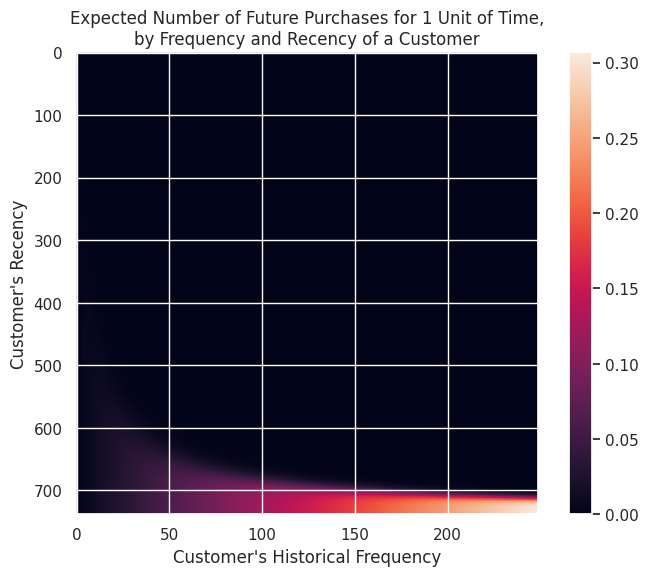

In [ ]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(pareto_nbd)

Ma trận sống (alive matrix) là một ma trận được sử dụng trong mô hình RFM (Recency-Frequency-Monetary) để ước lượng xác suất mà mỗi khách hàng sẽ tiếp tục mua hàng trong tương lai dựa trên hành vi mua hàng trong quá khứ của họ. Ma trận này hiển thị xác suất sống của mỗi khách hàng sau mỗi lần giao dịch, tức là khả năng rằng khách hàng sẽ tiếp tục mua hàng sau khi đã thực hiện một giao dịch. Ma trận sống thường được sử dụng trong các mô hình dự đoán giá trị cuộc sống của khách hàng (CLV), như mô hình Pareto-NBD, để đánh giá và dự đoán lâu dài giá trị của mỗi khách hàng cho doanh nghiệp.

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

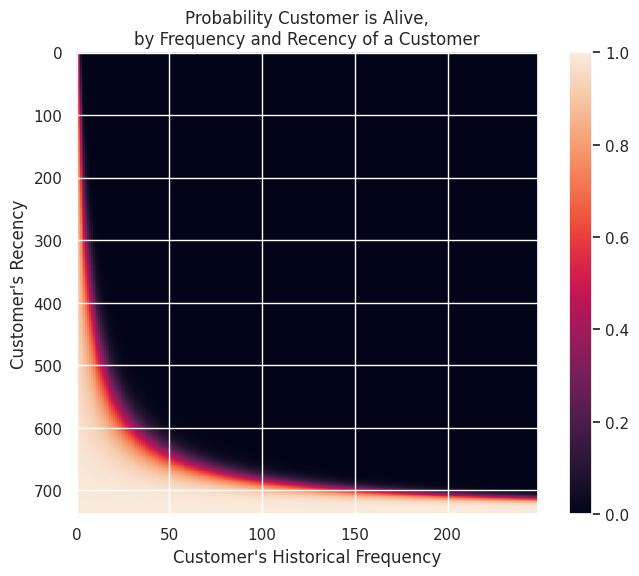

In [ ]:
plt.figure(figsize=(8,6))
# Sử dụng hàm plot_probability_alive_matrix từ thư viện lifetimes để vẽ ma trận xác suất alive
# Đối số pareto_nbd là mô hình Pareto-NBD đã được huấn luyện trước đó
plot_probability_alive_matrix(pareto_nbd)

In [ ]:
# Tính toán xác suất không sống (không tiếp tục mua hàng) của mỗi khách hàng
# Bằng cách lấy 1 trừ đi xác suất sống có điều kiện của mỗi khách hàng,
# Được ước lượng từ mô hình Pareto-NBD
summary_pnbd["p_not_alive"] = 1 - pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])

# Tính toán xác suất sống (tiếp tục mua hàng) của mỗi khách hàng
# Sử dụng xác suất sống có điều kiện của mỗi khách hàng,
# Được ước lượng từ mô hình Pareto-NBD
summary_pnbd["p_alive"] = pareto_nbd.conditional_probability_alive(summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])


In [ ]:
# Độ dài của khoảng thời gian tương lai (đơn vị: ngày)
t = 30

# Tính toán số lượng mua hàng dự kiến của mỗi khách hàng trong khoảng thời gian tương lai
# Bằng cách sử dụng phương thức conditional_expected_number_of_purchases_up_to_time của mô hình Pareto-NBD
summary_pnbd["predicted_purchases"] = pareto_nbd.conditional_expected_number_of_purchases_up_to_time(t, summary_pnbd["frequency"], summary_pnbd["recency"], summary_pnbd["T"])


In [ ]:
summary_pnbd.sort_values(by = "predicted_purchases").tail(5)


,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
2223,14606.0,176.0,735.0,736.0,167.237216,0.000183,0.999817,6.540771
5409,17841.0,192.0,736.0,737.0,354.136667,0.000185,0.999815,7.124080
2917,15311.0,195.0,738.0,738.0,583.837949,0.000000,1.000000,7.227391
394,12748.0,195.0,735.0,735.0,251.135333,0.000000,1.000000,7.254195
2521,14911.0,248.0,737.0,738.0,1123.968387,0.000192,0.999808,9.182545


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

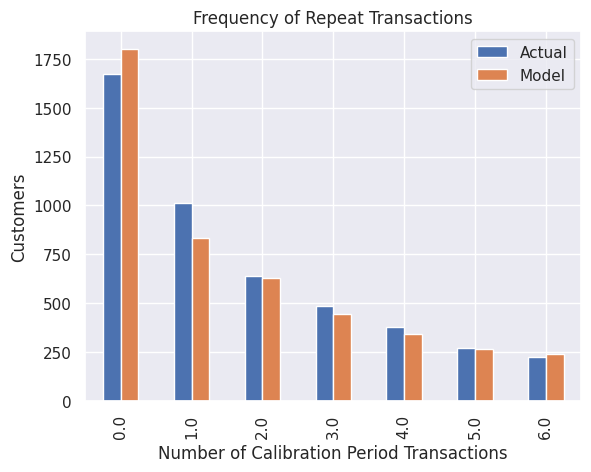

In [ ]:
plot_period_transactions(pareto_nbd)

**pareto_summary_cal_holdout**: Đây là một DataFrame chứa dữ liệu được chia thành hai phần: calibration period và holdout period. Calibration period là phần dữ liệu được sử dụng để huấn luyện mô hình, trong khi holdout period là phần dữ liệu được sử dụng để kiểm tra hiệu suất của mô hình.

In [ ]:
# Tạo dữ liệu calibration và holdout từ dữ liệu gốc, sử dụng hàm calibration_and_holdout_data từ thư viện lifetimes
# Đối số "data": DataFrame chứa dữ liệu RFM
# Đối số "Customer ID": Tên cột chứa định danh của khách hàng
# Đối số "InvoiceDate": Tên cột chứa ngày mua hàng
# Đối số "calibration_period_end": Ngày kết thúc của calibration period, ở đây là '2011-06-08'
# Đối số "observation_period_end": Ngày kết thúc của observation period (tổng thời gian quan sát), ở đây là '2011-12-09'
pareto_summary_cal_holdout = calibration_and_holdout_data(df, "Customer ID", "InvoiceDate",
                                                         calibration_period_end='2011-06-08',
                                                         observation_period_end='2011-12-09')


In [ ]:
pareto_summary_cal_holdout.head()


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,2.0,322.0,463.0,0.0,184.0
12347.0,3.0,158.0,220.0,4.0,184.0
12348.0,3.0,190.0,254.0,1.0,184.0
12349.0,1.0,182.0,405.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0


In [ ]:
pareto_nbd.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4936 subjects, alpha: 75.49, beta: 3351.87, r: 0.75, s: 1.33>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

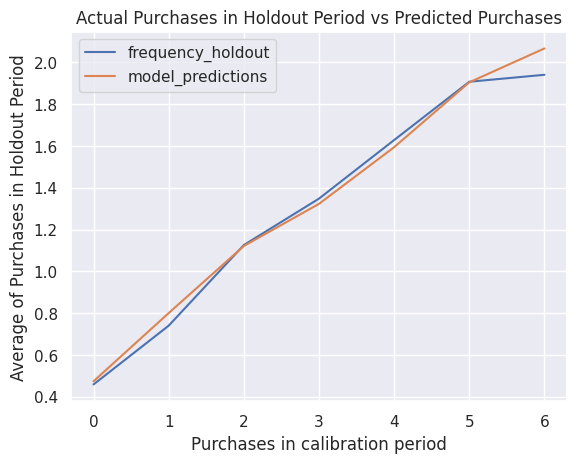

In [ ]:
#vẽ biểu đồ so sánh số lượng mua hàng được dự đoán trong calibration period và holdout period bởi mô hình Pareto-NBD
plot_calibration_purchases_vs_holdout_purchases(pareto_nbd, pareto_summary_cal_holdout)


In [ ]:
def pareto_get_pred_error(t, id_):
    """
    Dự đoán giá trị mua hàng trong tương lai dựa trên cửa sổ tìm kiếm và đánh giá sai số.

    Tham số:
    - t: Số ngày trong tương lai muốn dự đoán.
    - id_: ID của khách hàng muốn dự đoán.

    """

    # Lấy dữ liệu của khách hàng cụ thể
    individual_p = summary_pnbd[summary_pnbd["Customer ID"] == id_]

    # Dự đoán giá trị mua hàng cho khách hàng cụ thể
    ind_pred_p = pareto_nbd.predict(t, individual_p["frequency"], individual_p["recency"], individual_p["T"])

    # Tính giá trị mua hàng thực tế cho khách hàng cụ thể
    actual_val_p = individual_p["frequency"] / individual_p["recency"] * t

    # Tính sai số giữa giá trị dự đoán và giá trị thực tế
    error = actual_val_p - ind_pred_p

    # In kết quả dự đoán, giá trị thực tế và sai số
    print("Số lượng mua hàng dự đoán: %s" % (ind_pred_p))
    print("Số lượng mua hàng thực tế: %s" % (actual_val_p))
    print("Sai số dự đoán: %s" % (error))


In [ ]:
pareto_get_pred_error(30, 12346.0)


Số lượng mua hàng dự đoán: 0    0.088338
dtype: float64
Số lượng mua hàng thực tế: 0    0.186335
dtype: float64
Sai số dự đoán: 0    0.097997
dtype: float64


In [ ]:
# Tính toán số lượng mua hàng thực tế dự kiến trong 30 ngày tiếp theo cho mỗi khách hàng
# Bằng cách lấy số lượng mua hàng hiện tại của mỗi khách hàng và nhân với 30 (số ngày trong tương lai)
summary_pnbd["actual_30_p"] = summary_pnbd["frequency"] / summary_pnbd["recency"] * 30


In [ ]:
summary_pnbd["actual_30_p"].fillna(0, inplace = True)


In [ ]:
# Tính toán sai số giữa số lượng mua hàng thực tế dự kiến trong 30 ngày tiếp theo và số lượng mua hàng được dự đoán bởi mô hình Pareto-NBD
summary_pnbd["p_error"] = summary_pnbd["actual_30_p"] - summary_pnbd["predicted_purchases"]


In [ ]:
print("Mean Squared Error: %s" % mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_pnbd["actual_30_p"], summary_pnbd["predicted_purchases"])))
print("Average Purchase Error: %s" %(summary_pnbd["p_error"].mean()))


Mean Squared Error: 2.0678603955946318
Root Mean Squared Error: 1.4380057008213256
Average Purchase Error: 0.22546972179471503


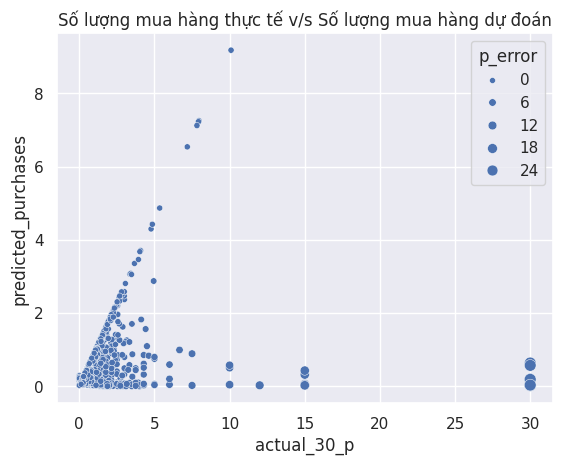

In [ ]:
#biểu đồ scatterplot với trục x là số lượng mua hàng thực tế dự kiến trong 30 ngày tiếp theo
#và trục y là số lượng mua hàng được dự đoán bởi mô hình Pareto-NBD.
#Kích thước của mỗi điểm trên biểu đồ sẽ thể hiện sai số giữa dự đoán và giá trị thực tế, với các điểm lớn hơn thể hiện sai số lớn hơn.
# Vẽ biểu đồ scatterplot
sns.scatterplot(data=summary_pnbd, x="actual_30_p", y="predicted_purchases", size="p_error")

# Đặt tiêu đề cho biểu đồ
plt.title("Số lượng mua hàng thực tế v/s Số lượng mua hàng dự đoán")

# Hiển thị biểu đồ
plt.show()

In [ ]:
summary_copy = summary_pnbd.copy()


In [ ]:
# Lọc các hàng trong DataFrame summary_copy sao cho chỉ bao gồm các hàng có số lần mua hàng lớn hơn 0 và giá trị tiền lớn hơn 0
# loại bỏ các hàng không có giao dịch hoặc có giao dịch không đáng kể
summary_copy = summary_copy[(summary_copy["frequency"] > 0) & (summary_copy["monetary_value"] > 0)]


<Axes: >

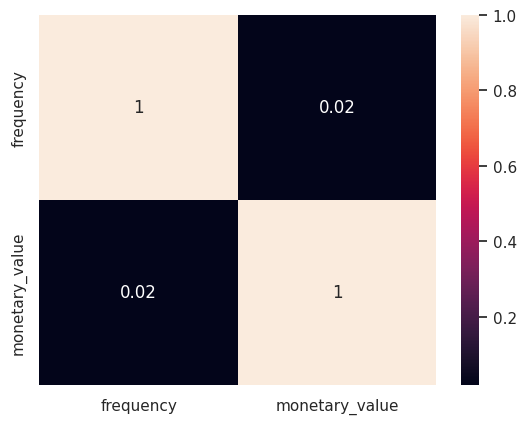

In [ ]:
sns.heatmap(summary_copy[["frequency", "monetary_value"]].corr(), annot = True)


In [ ]:
ggf_p = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)


In [ ]:
ggf_p.fit(summary_copy["frequency"], summary_copy["monetary_value"])


<lifetimes.GammaGammaFitter: fitted with 4179 subjects, p: 2.23, q: 3.49, v: 444.13>

In [ ]:
ggf_p.summary


,coef,se(coef),lower 95% bound,upper 95% bound
p,2.226234,0.112592,2.005554,2.446913
q,3.488383,0.110264,3.272265,3.704500
v,444.128389,34.419099,376.666955,511.589822


In [ ]:
summary_copy["expected_avg_sales_p"] = ggf_p.conditional_expected_average_profit(summary_copy["frequency"],
                                                                        summary_copy["monetary_value"])

In [ ]:
summary_copy.head()


,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p
0,12346.0,2.0,322.0,647.0,38662.955000,0.151228,0.848772,0.096803,0.186335,0.089532,24944.247004
1,12347.0,7.0,402.0,404.0,615.714286,0.000470,0.999530,0.485549,0.522388,0.036839,585.645746
2,12348.0,4.0,363.0,438.0,359.310000,0.025466,0.974534,0.270704,0.330579,0.059875,367.615990
3,12349.0,2.0,571.0,589.0,1305.085000,0.003544,0.996456,0.123592,0.105079,-0.018513,979.646854
6,12352.0,8.0,356.0,392.0,198.223750,0.012422,0.987578,0.555670,0.674157,0.118488,222.633587


In [ ]:
avg_purchase_error = summary_copy["monetary_value"].mean() - summary_copy["expected_avg_sales_p"].mean()


In [ ]:
print("Acutal Avg Sales: %s" % summary_copy["monetary_value"].mean())
print("Predicted Avg Sales: %s" % summary_copy["expected_avg_sales_p"].mean())
print("Mean Sqaured Error: %s" % mean_squared_error(summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"]))
print("Root Mean Sqaured Error: %s" % sqrt(mean_squared_error(summary_copy["monetary_value"], summary_copy["expected_avg_sales_p"])))
print("Avg Sales Error: %s" % avg_purchase_error)

Acutal Avg Sales: 442.3732608248961
Predicted Avg Sales: 428.2011315336284
Mean Sqaured Error: 1972967.0993665527
Root Mean Sqaured Error: 1404.623472453224
Avg Sales Error: 14.172129291267652


In [ ]:
actual = summary_copy["actual_30_p"] * summary_copy["monetary_value"]
predicted = summary_copy["predicted_purchases"] * summary_copy["expected_avg_sales_p"]

In [ ]:
error = actual-predicted


In [ ]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T


In [ ]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: 124.72427895573074
Mean Squared Error: 1134602.917035051
Root Mean Squared Error: 1065.1774110612048


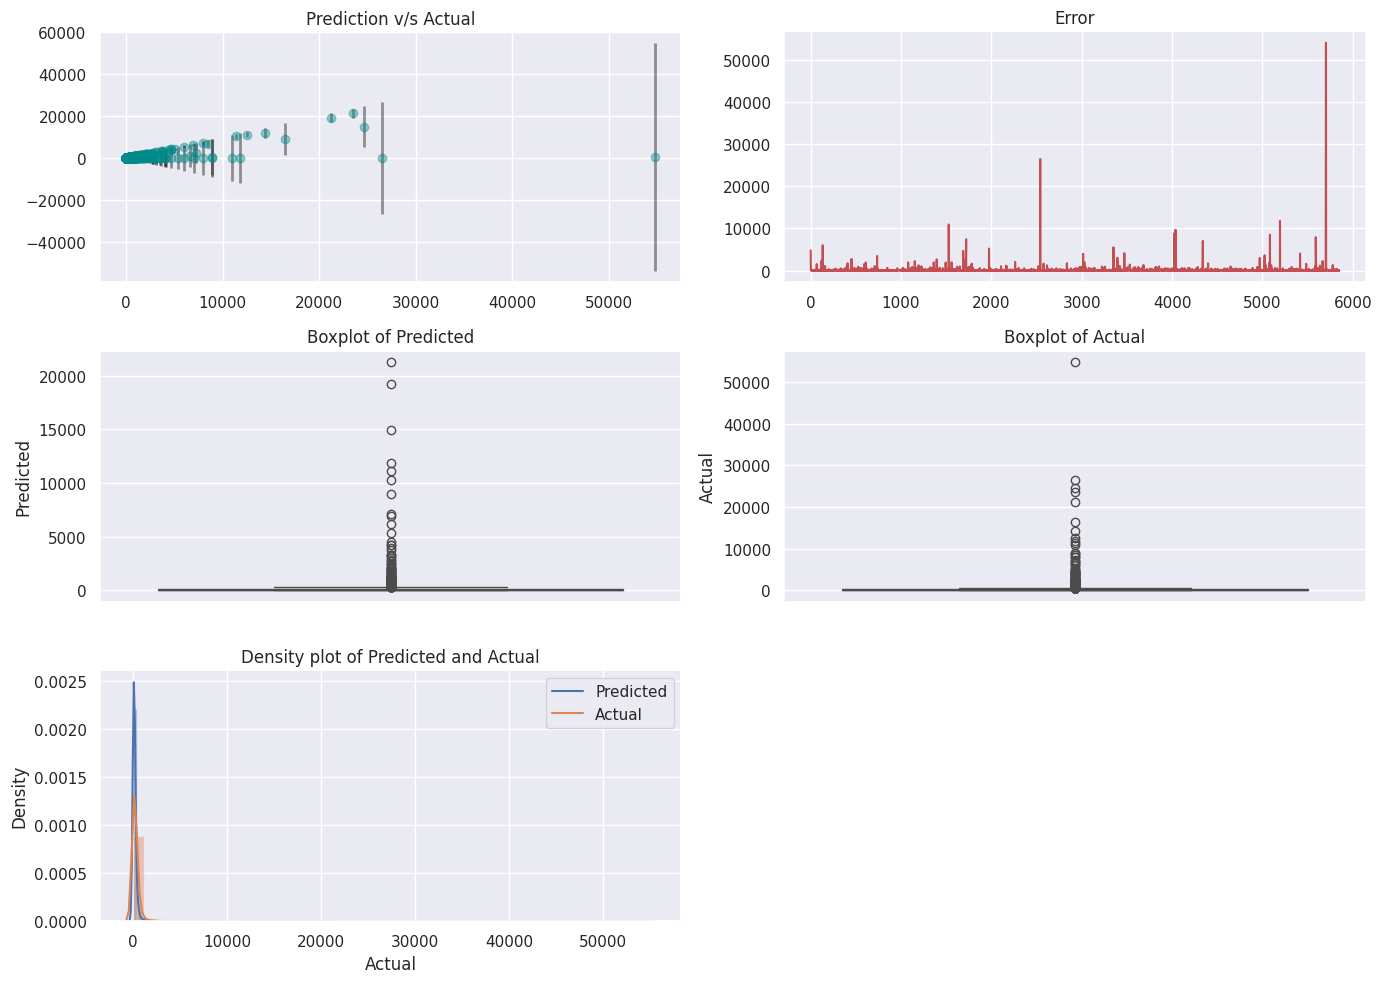

In [ ]:
plt.figure(figsize=(14, 10))

# Biểu đồ Prediction v/s Actual
plt.subplot(321)
plt.errorbar(result_p["Actual"], result_p["Predicted"], yerr=np.abs(result_p["Error"]), fmt='o', color='darkcyan',
             ecolor='black', elinewidth=2, capsize=0, alpha=0.4)
plt.title("Prediction v/s Actual")

# Biểu đồ Error
plt.subplot(322)
plt.plot(result_p["Error"], color='r')
plt.title("Error")

# Biểu đồ Boxplot của Predicted và Actual
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.title("Boxplot of Predicted")

plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.title("Boxplot of Actual")

# Biểu đồ Density plot của Predicted và Actual
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.title("Density plot of Predicted and Actual")

plt.tight_layout()
plt.show()

In [ ]:
summary_copy["predicted_clv_p"] = ggf_p.customer_lifetime_value(pareto_nbd,
                                                       summary_copy["frequency"],
                                                       summary_copy["recency"],
                                                       summary_copy["T"],
                                                       summary_copy["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [ ]:
summary_copy.shape

(4179, 12)

In [ ]:
summary_copy["CLV_p"] = summary_copy["predicted_clv_p"]*0.05


In [ ]:
summary_copy.head()


,Customer ID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual_30_p,p_error,expected_avg_sales_p,predicted_clv_p,CLV_p
0,12346.0,2.0,322.0,647.0,38662.955000,0.151228,0.848772,0.096803,0.186335,0.089532,24944.247004,50199.973481,2509.998674
1,12347.0,7.0,402.0,404.0,615.714286,0.000470,0.999530,0.485549,0.522388,0.036839,585.645746,6385.156454,319.257823
2,12348.0,4.0,363.0,438.0,359.310000,0.025466,0.974534,0.270704,0.330579,0.059875,367.615990,2210.441820,110.522091
3,12349.0,2.0,571.0,589.0,1305.085000,0.003544,0.996456,0.123592,0.105079,-0.018513,979.646854,2736.737798,136.836890
6,12352.0,8.0,356.0,392.0,198.223750,0.012422,0.987578,0.555670,0.674157,0.118488,222.633587,2760.189523,138.009476
